In [1]:
from IPython.display import display

from sympy import *
init_printing()

from monom import *

In [2]:
t, x, y, tau, h, Re, p0 = symbols(r't, x, y, tau, h, Re, p_0', real=True)
u, v, p = (f(t, x, y) for f in symbols('u, v, p', cls=Function))

In [3]:
pda_f, pda_v = (u, v, p), (t, x, y)
pda_n, pda_clp = 5, 3
pda_p = Rational(0, 1), Rational(0, 1), Rational(0, 1)

In [4]:
Monom.variables = 1 + len(pda_v)
Monom.cmp = Monom.TOPdeglex
Monom.zero = Monom(0 for v in range(Monom.variables))
pda_fun = dict(zip(pda_f,\
             (Monom(0 if v else i for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))
pda_var = dict(zip(pda_v,\
             (Monom(0 if v != i else 1 for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))

In [5]:
def T(f, i1, j1, k1):
    return sum(sum(sum(\
        diff(f, t, i, x, j, y, k)*(tau*(i1+pda_p[0]))**i \
                                   *(h*(j1+pda_p[1]))**j \
                                   *(h*(k1+pda_p[2]))**k/\
                 (factorial(i)*factorial(j)*factorial(k))\
        for i in range(pda_n-j-k))\
        for k in range(pda_n-j))  \
        for j in range(pda_n))

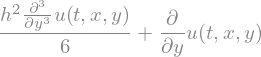

In [6]:
expand((T(u, 0, 0, 1)-T(u, 0, 0, -1))/(2*h))

In [7]:
def clip(f):
    f = f.expand()
    return [f.coeff(tau, 0).coeff(h, 0),\
            f.coeff(h, 0).coeff(tau, 1),\
            f.coeff(tau, 0).coeff(h, 2)]

def df2m(a):
    assert a.func == Derivative
    m = pda_fun[a.args[0]]
    for xi in a.args[1:]:
        if isinstance(xi, Symbol):
            m = m*pda_var[xi]
        else:
            m = m*pda_var[xi[0]]**xi[1]
    return m

def m2df(m):
    r = pda_f[m[0]-1]
    for i in range(1, len(m)):
        r = r.diff(pda_v[i-1], m[i])
    return r

def findDiv(a, d):
    r = None
    def find(a, r):
        if a.args:
            if a.func == Derivative and a.args[0] in pda_fun:
                m = df2m(a)
                if m.divisible(d) and (not r or m.cmp(r) > 0):
                    r = m
            else:
                for s in a.args:
                    r = find(s, r)
        return r
    return find(a, r)

def reduction(f1, f2, m, c, shift):
    assert shift < pda_clp
    r = [f1[i] for i in range(shift)]
    if not m:
        for i in range(shift, pda_clp):
            r.append(expand(f1[i] - f2[i-shift]*c))
    else:
        for i in range(shift, pda_clp):
            r.append(expand(f1[i] - f2[i-shift].diff(*m)*c))
    return r

def NF(f, df, G, head=False, trace=False):
    assert len(df) == len(G)
#     print(df2m(df[0]))
    ms = [df2m(d) for d in df]
    for i in range(0 if head else 1, pda_clp):
        t = 0
        if f[i]:
            while True:
                r = None
                for l in range(len(ms)):
                    r = findDiv(f[i], ms[l])
                    if r:
                        break
                if not r: 
                    break
                c, deg, m = 0, 7, m2df(r)
                while c == 0:
                    c = f[i].coeff(m, deg)
                    deg -= 1
                    assert deg >= 0
#                 print(c, m, deg+1)
                if deg:
                    c *= m**deg
                m = r/ms[l]
                d = []
                for k in range(len(pda_v)):
                    if m[k+1] > 0:
                        d.append(pda_v[k])
                        if m[k+1] > 1:
                            d.append(m[k+1])
                if trace:
                    print(">"*12)
                    eq = Symbol("eq%d" % (l+1), real=True)
                    if d:
                        display(Derivative(*tuple([eq] + d))*c*h**i)
                    else:
                        display(eq*c*h**i)
                f = reduction(f, G[l], tuple(d), c/G[l][0].coeff(df[l]), i)
                if trace:
                    print("res =")
                    display(f)
                    print("<"*12)
                t += 1
#                 if t > 6: break
    return f

def prn(a):
    display(a[0])
    print("tau =>")
    display(a[1])
    print("h^2 =>")
    display(a[2])

In [8]:
def Dt(a):
    return (T(a, 1, 0, 0) - a)/(tau)
def Dx(a):
    return (T(a, 0, 1, 0) - T(a, 0, -1, 0))/(2*h)
def Dy(a):
    return (T(a, 0, 0, 1) - T(a, 0, 0, -1))/(2*h)

def DD(a):
    return (T(a, 0, 1, 0) + T(a, 0, 0, 1) +\
                        -4*a +\
           T(a, 0, -1, 0) + T(a, 0, 0, -1))/h**2

def DD2(a):
    return (T(a, 0, 2, 0) + T(a, 0, 0, 2) +\
                        -4*a +\
           T(a, 0, -2, 0) + T(a, 0, 0, -2))/(4*h**2)

def Dxx(a):
    return (T(a, 0, 2, 0) - 2*a + T(a, 0, -2, 0))/(4*h**2)
def Dxy(a):
    return (T(a, 0, 1, 1) - T(a, 0, 1, -1) -\
            T(a, 0, -1, 1) + T(a, 0, -1, -1))/(4*h**2)
def Dyy(a):
    return (T(a, 0, 0, 2) - 2*a + T(a, 0, 0, -2))/(4*h**2)

def DDx(a):
    return ((T(a, 0, 2, 0) + T(a, 0, 1, 1) -\
             4*T(a, 0, 1, 0) + T(a, 0, 1, -1)) -\
            (T(a, 0, -1, 1) - 4*T(a, 0, -1, 0) +\
             T(a, 0, -2, 0) + T(a, 0, -1, -1)))/(2*h**3)
def DDy(a):
    return ((T(a, 0, 1, 1) + T(a, 0, 0, 2) -\
             4*T(a, 0, 0, 1) + T(a, 0, -1, 1)) -\
            (T(a, 0, 1, -1) - 4*T(a, 0, 0, -1) +\
             T(a, 0, -1, -1) + T(a, 0, 0, -2)))/(2*h**3)

**Taylor decaying**

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq1}
\left\lbrace 
\begin{array}{l}
 u = -e^{-2t/\mathrm{Re}} \cos(x) \sin(y) ,\\
 v =  e^{-2t/\mathrm{Re}} \sin(x) \cos(y) ,\\
 p = -e^{-4t/\mathrm{Re}} (\cos(2x) + \cos(2y))/4 ,
\end{array}
\right. 
\end{equation} 

In [9]:
TD = {u: -exp(-2*t/Re)*cos(x)*sin(y),\
      v:  exp(-2*t/Re)*sin(x)*cos(y),\
      p: -exp(-4*t/Re)*(cos(2*x)+cos(2*y))/4}

**Kovasznay flow**

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq2}
\left\lbrace 
\begin{array}{l}
 u = 1-e^{\lambda x} \cos(2 \pi y) ,\\
 v = \lambda/{2\pi} e^{\lambda x} \sin(2 \pi y) ,\\
 p = p_0-\frac{1}{2}e^{2\lambda x} ,
\end{array}
\right. 
\end{equation}
where $\lambda = \mathrm{Re}/2-\sqrt{\mathrm{Re}^2/4+4\pi^2}$.

In [10]:
Lambda = Re/2 - sqrt(Re**2/4 + 4*pi**2)
KF = {u: 1 - exp(Lambda*x)*cos(2*pi*y),\
      v: Lambda/(2*pi)*exp(Lambda*x)*sin(2*pi*y),\
      p: p0 - exp(2*Lambda*x)/2}

# FDA1

Amodio Pierluigi, Blinkov Yuri, Gerdt Vladimir, La Scala Roberto Algebraic construction and numerical behavior of a new s-consistent difference scheme for the 2D Navier–Stokes equations. Applied Mathematics and Computation, 2017, vol. 314, pp. 408-421. DOI: 10.1016/j.amc.2017.06.037 Available at: http://www.sciencedirect.com/science/article/pii/S0096300317304502

page 415

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{D_1}(u) + \operatorname{D_2}(v)=0 ,\\[4pt]
F^2:& \operatorname{D_t}(u) + \operatorname{D_1}(u^2)+
\operatorname{D_2}(vu) + 
\operatorname{D_1}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (u)
=0 ,\\[4pt]
F^3:& \operatorname{D_t}(v) + \operatorname{D_1}(uv)+
\operatorname{D_2}(v^2) +
\operatorname{D_2}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (v)
=0 ,\\[4pt]
F^4:& \left(\operatorname{D_1}^2 + \operatorname{D_2}^2\right)(p) + \operatorname{D_1}^2(u^2) + \operatorname{D_2}^2(v^2) + {} \\
&{} + 2\operatorname{D_1}\operatorname{D_2}(uv)
- \frac{1}{\mathrm{Re}}\tilde{\Delta}(F^1)
=0 .
\end{array}
\right. 
\end{equation}

In [11]:
F1 = clip(Dx(u) + Dy(v))
F2 = clip(Dt(u) + Dx(u**2) + Dy(v*u) +  Dx(p) - DD(u)/Re)
F3 = clip(Dt(v) + Dx(u*v) +  Dy(v**2) + Dy(p) - DD(v)/Re)
F4 = clip(DD2(p) + Dxx(u**2) + Dyy(v**2) + 2*Dxy(u*v) - (DDx(u) + DDy(v))/Re)

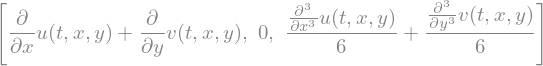

In [12]:
F1

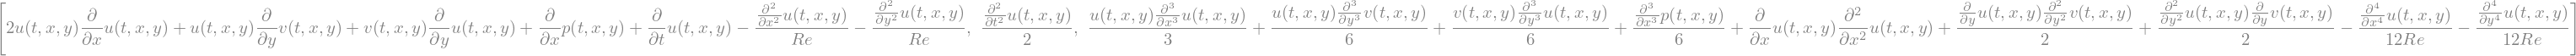

In [13]:
F2

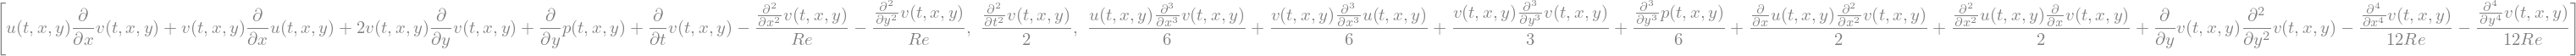

In [14]:
F3

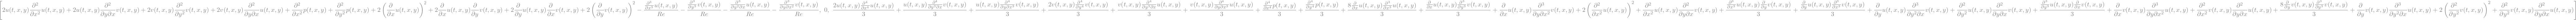

In [15]:
F4

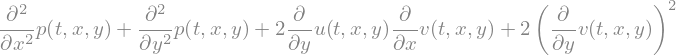

tau =>


h^2 =>


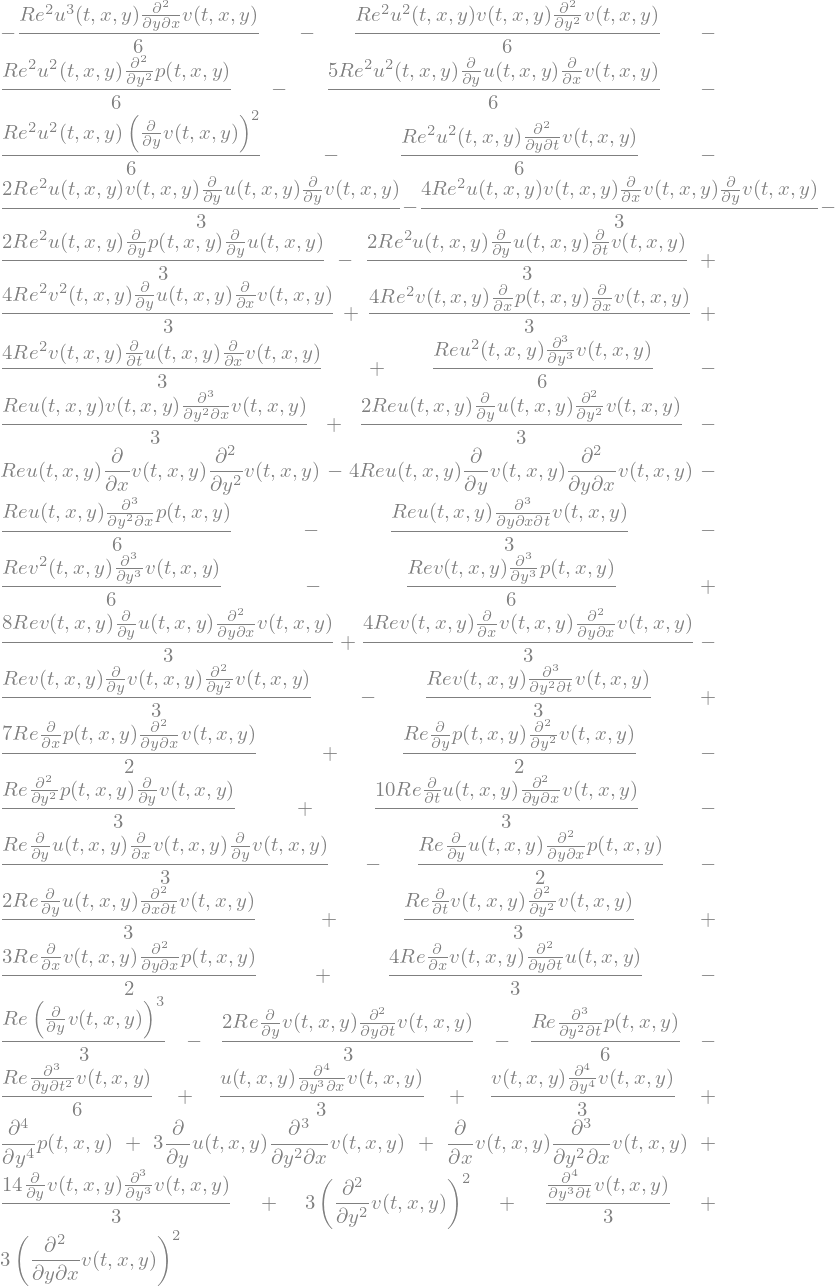

In [16]:
f4 = NF(F4, [u.diff(x), u.diff(y, 2), v.diff(x, 2)], [F1, F2, F3], head=True)
f4 = NF(f4, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [F1, F2, F3, f4])
prn(f4)

In [17]:
prn([f.subs(TD).doit().simplify() for f in f4])

tau =>


h^2 =>


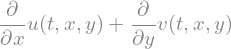

tau =>


h^2 =>


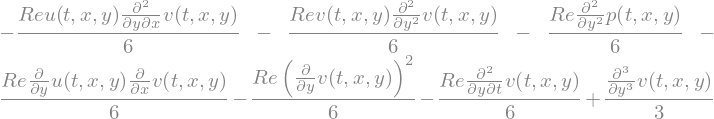

In [18]:
f1 = NF(F1, [u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [F2, F3, f4], head=True)
f1 = NF(f1, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, F2, F3, f4])
prn(f1)

In [19]:
prn([f.subs(TD).doit().simplify() for f in f1])

tau =>


h^2 =>


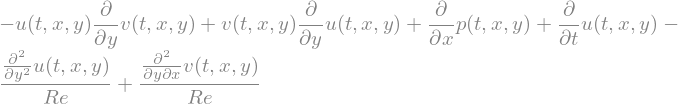

tau =>


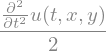

h^2 =>


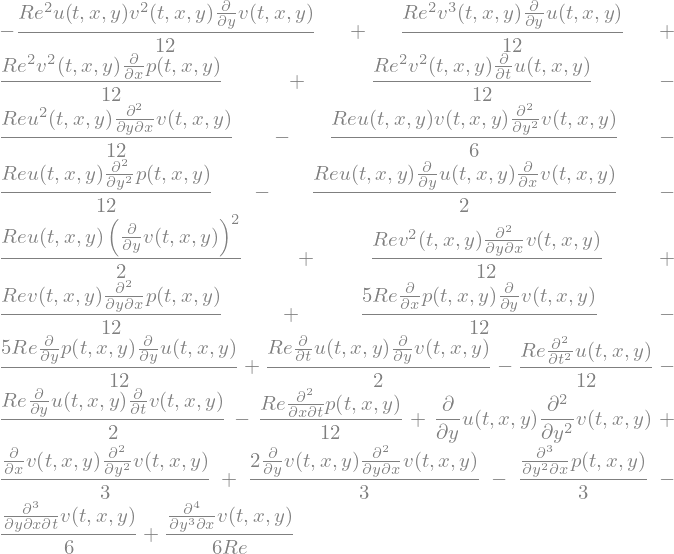

In [20]:
f2 = NF(F2, [u.diff(x), v.diff(x, 2), p.diff(x, 2)], [f1, F3, f4], head=True)
f2 = NF(f2, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, F3, f4])
prn(f2)

tau =>


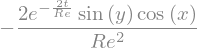

h^2 =>


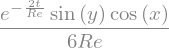

In [21]:
prn([f.subs(TD).doit().simplify() for f in f2])

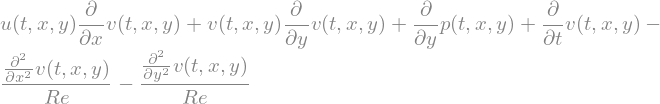

tau =>


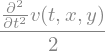

h^2 =>


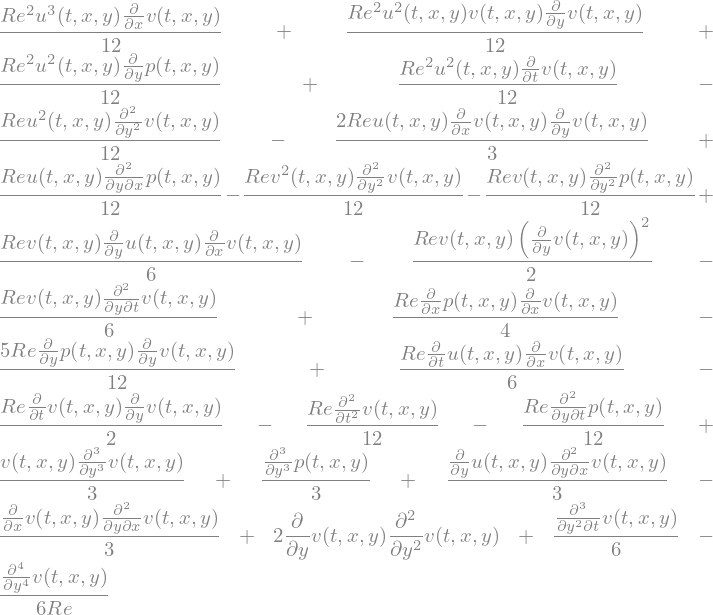

In [22]:
f3 = NF(F3, [u.diff(x), u.diff(y, 2), p.diff(x, 2)], [f1, f2, f4], head=True)
f3 = NF(f3, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, f3, f4])
prn(f3)

tau =>


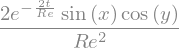

h^2 =>


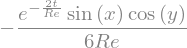

In [23]:
prn([f.subs(TD).doit().simplify() for f in f3])

tau =>


h^2 =>


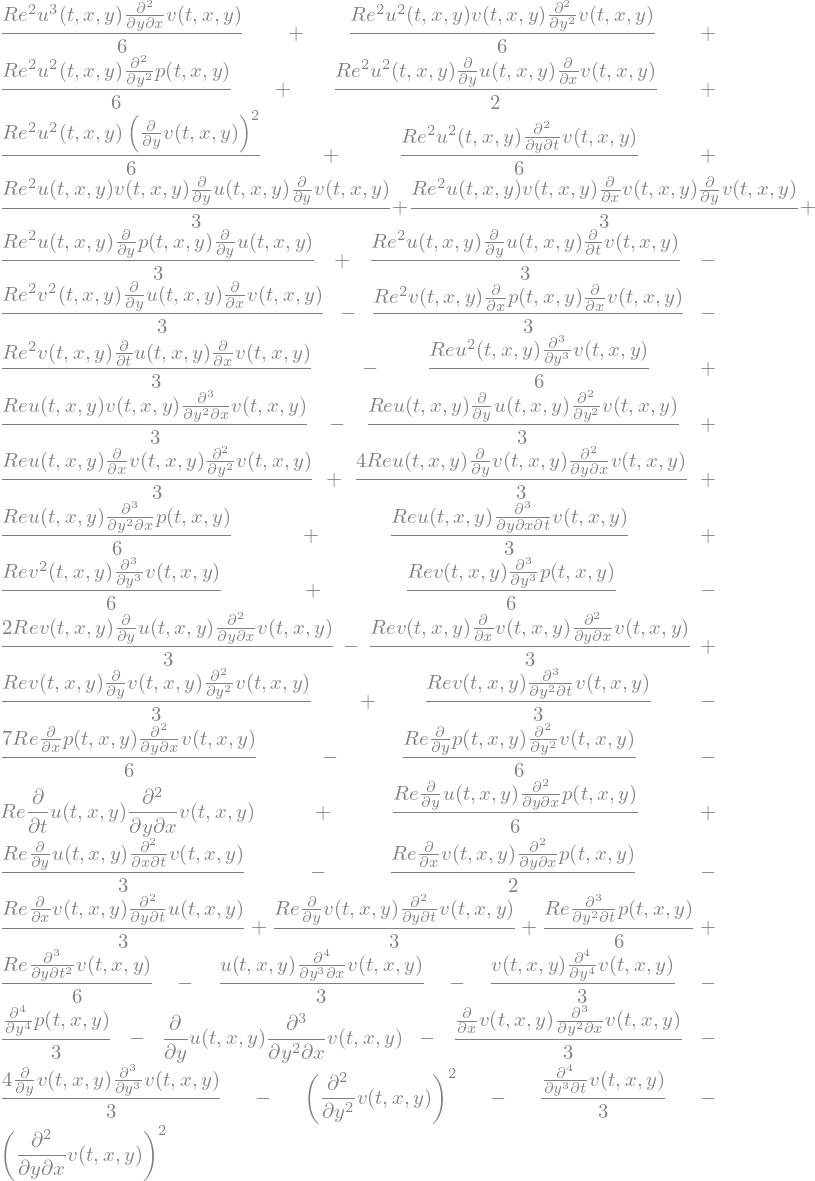

In [24]:
spoly = [a.diff(x) + b.diff(y) for a, b in zip(f2, f3)]
spoly = NF(spoly, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, f3, f4], head=True)
prn(spoly)

In [25]:
prn([f.subs(TD).doit().simplify() for f in spoly])

tau =>


h^2 =>


tau =>


h^2 =>


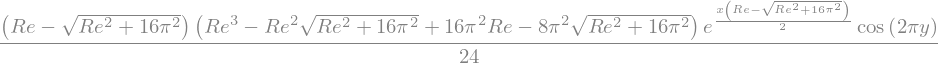

In [26]:
prn([f.subs(KF).doit().simplify() for f in spoly])

# FDA2

Hans Johnston and Jian-Guo Liu, Finite Difference Schemes for Incompressible Flow Based on Local Pressure Boundary Conditions. Journal of Computational Physics 180, 120–154 (2002) doi:10.1006/jcph.2002.7079

page 126

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{D_1}(u) + \operatorname{D_2}(v)=0 ,\\[4pt]
F^2:& \operatorname{D_t}(u) + u\operatorname{D_1}(u)+
v\operatorname{D_2}(u) + 
\operatorname{D_1}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (u)
=0 ,\\[4pt]
F^3:& \operatorname{D_t}(v) + u\operatorname{D_1}(v)+
v\operatorname{D_2}(v) +
\operatorname{D_2}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (v)
=0 ,\\[4pt]
F^4:& \tilde{\Delta}(p) 
- 2\operatorname{D_1}(u)\operatorname{D_2}(v)
+ 2\operatorname{D_1}(v)\operatorname{D_2}(u)
=0 .
\end{array}
\right. 
\end{equation}

In [27]:
F1 = clip(Dx(u) + Dy(v))
F2 = clip(Dt(u) + u*Dx(u) + v*Dy(u) + Dx(p) - DD(u)/Re)
F3 = clip(Dt(v) + u*Dx(v) + v*Dy(v) + Dy(p) - DD(v)/Re)
F4 = clip(DD2(p) - 2*Dx(u)*Dy(v) + 2*Dx(v)*Dy(u))

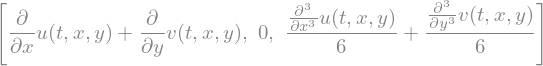

In [28]:
F1

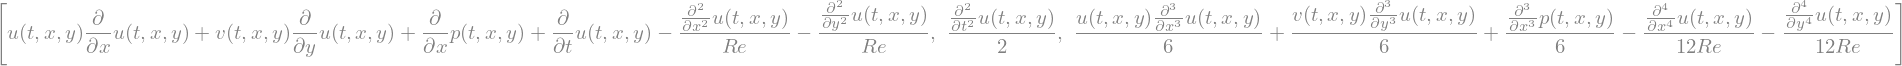

In [29]:
F2

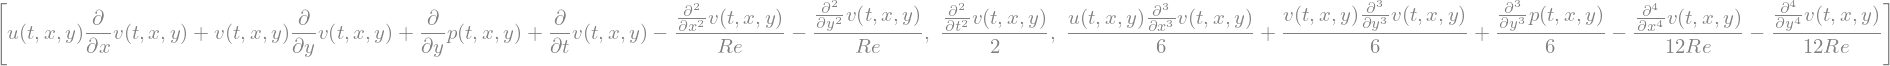

In [30]:
F3

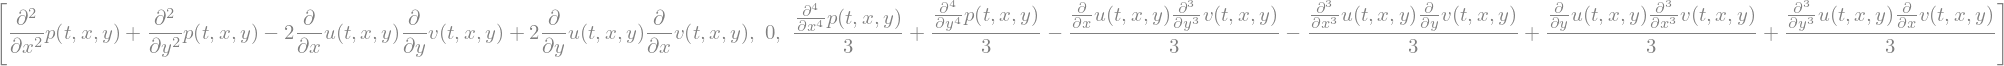

In [31]:
F4

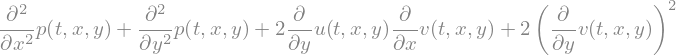

tau =>


h^2 =>


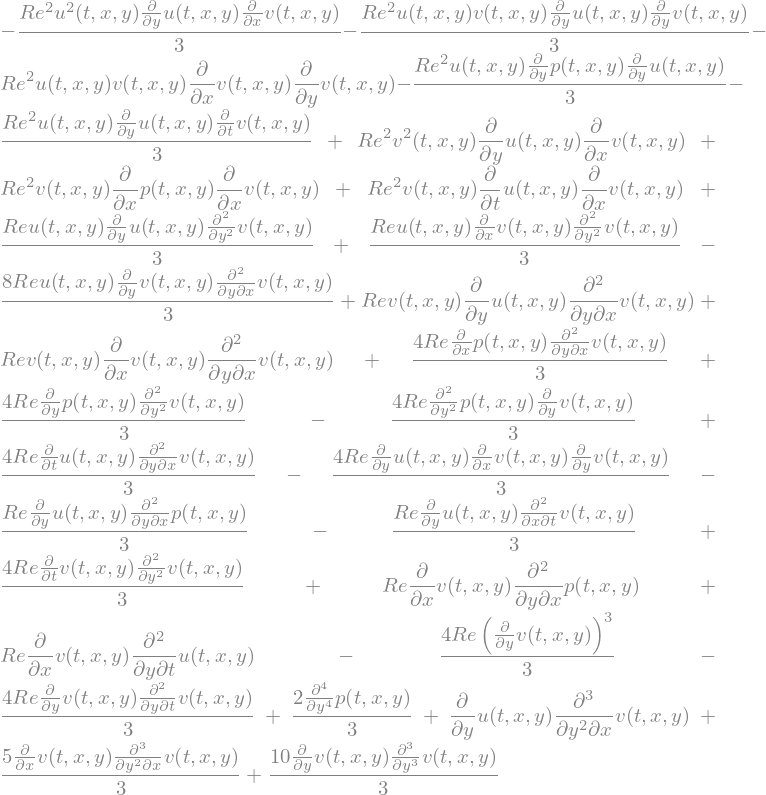

In [32]:
f4 = NF(F4, [u.diff(x), u.diff(y, 2), v.diff(x, 2)], [F1, F2, F3], head=True)
f4 = NF(f4, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [F1, F2, F3, f4])
prn(f4)

In [33]:
prn([f.subs(TD).doit().simplify() for f in f4])

tau =>


h^2 =>


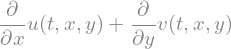

tau =>


h^2 =>


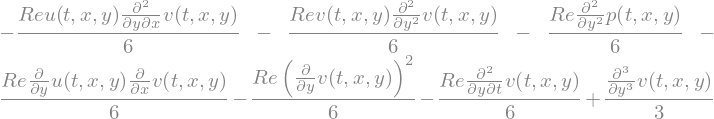

In [34]:
f1 = NF(F1, [u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [F2, F3, f4], head=True)
f1 = NF(f1, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, F2, F3, f4])
prn(f1)

In [35]:
prn([f.subs(TD).doit().simplify() for f in f1])

tau =>


h^2 =>


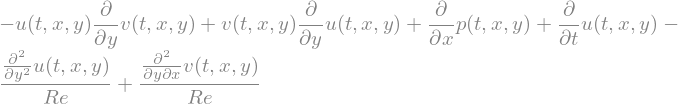

tau =>


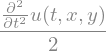

h^2 =>


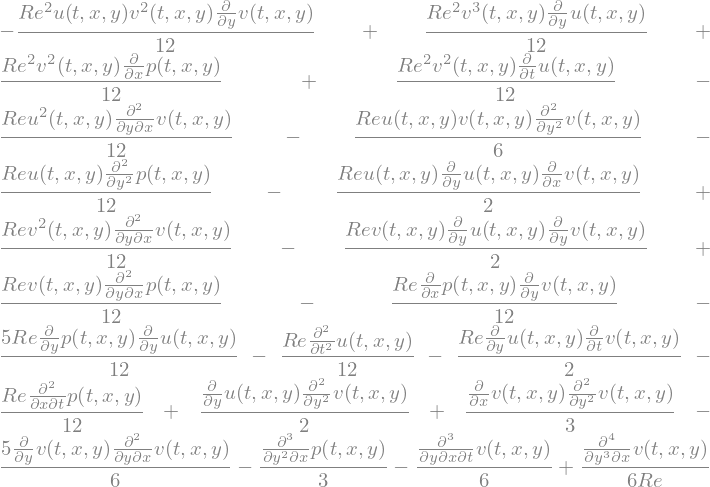

In [36]:
f2 = NF(F2, [u.diff(x), v.diff(x, 2), p.diff(x, 2)], [f1, F3, f4], head=True)
f2 = NF(f2, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, F3, f4])
prn(f2)

tau =>


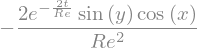

h^2 =>


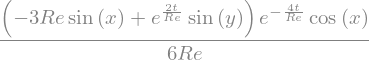

In [37]:
prn([f.subs(TD).doit().simplify() for f in f2])

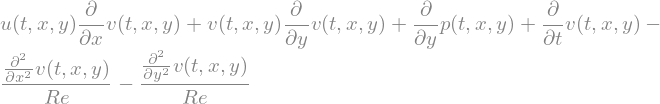

tau =>


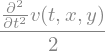

h^2 =>


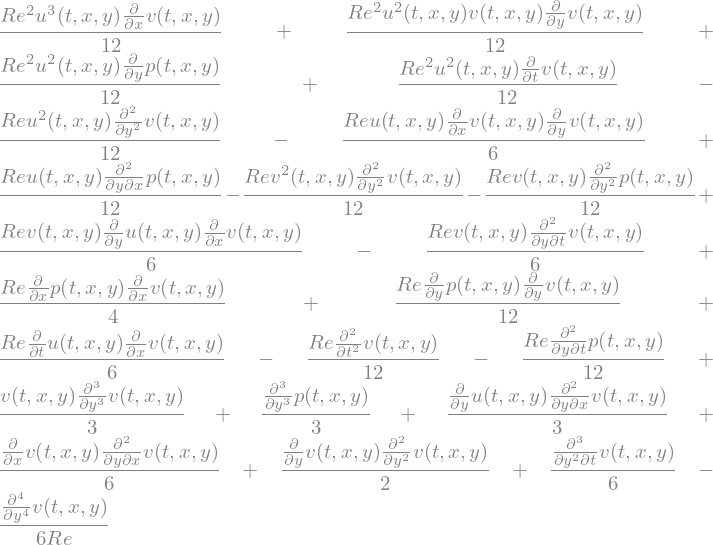

In [38]:
f3 = NF(F3, [u.diff(x), u.diff(y, 2), p.diff(x, 2)], [f1, f2, f4], head=True)
f3 = NF(f3, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, f3, f4])
prn(f3)

tau =>


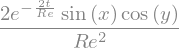

h^2 =>


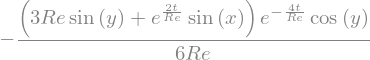

In [39]:
prn([f.subs(TD).doit().simplify() for f in f3])

tau =>


h^2 =>


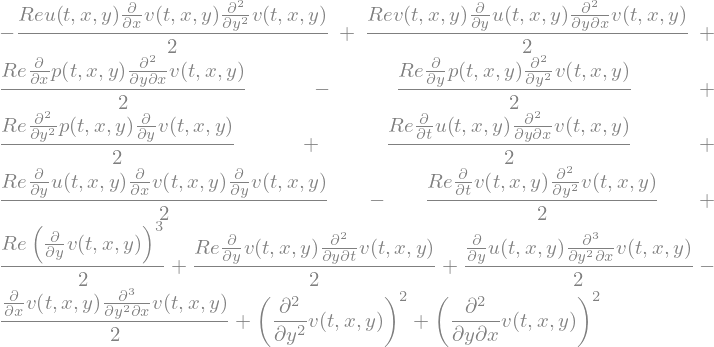

In [40]:
spoly = [a.diff(x) + b.diff(y) for a, b in zip(f2, f3)]
spoly = NF(spoly, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, f3, f4], head=True)
prn(spoly)

tau =>


h^2 =>


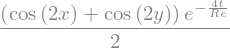

In [41]:
prn([f.subs(TD).doit().simplify() for f in spoly])

tau =>


h^2 =>


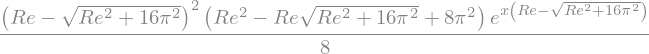

In [42]:
prn([f.subs(KF).doit().simplify() for f in spoly])

# FDA3

Amodio Pierluigi, Blinkov Yuri, Gerdt Vladimir, La Scala Roberto Algebraic construction and numerical behavior of a new s-consistent difference scheme for the 2D Navier–Stokes equations. Applied Mathematics and Computation, 2017, vol. 314, pp. 408-421. DOI: 10.1016/j.amc.2017.06.037 

Available at: http://www.sciencedirect.com/science/article/pii/S0096300317304502

page 417

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{D_1}(u) + \operatorname{D_2}(v)=0 ,\\[4pt]
F^2:& \operatorname{D_t}(u) + \operatorname{D_1}(u^2)+
\operatorname{D_2}(vu) + 
\operatorname{D_1}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (u)
=0 ,\\[4pt]
F^3:& \operatorname{D_t}(v) + \operatorname{D_1}(uv)+
\operatorname{D_2}(v^2) +
\operatorname{D_2}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (v)
=0 ,\\[4pt]
F^4:& \left(\operatorname{D_1}^2 + \operatorname{D_2}^2\right)(p) + \operatorname{D_1}^2(u^2) + \operatorname{D_2}^2(v^2) + {} \\
&{} + 2\operatorname{D_1}\operatorname{D_2}(uv)
=0 .
\end{array}
\right. 
\end{equation}

In [43]:
F1 = clip(Dx(u) + Dy(v))
F2 = clip(Dt(u) + Dx(u**2) + Dy(v*u) +  Dx(p) - DD(u)/Re)
F3 = clip(Dt(v) + Dx(u*v) +  Dy(v**2) + Dy(p) - DD(v)/Re)
F4 = clip(DD2(p) + Dxx(u**2) + Dyy(v**2) + 2*Dxy(u*v))

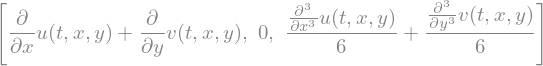

In [44]:
F1

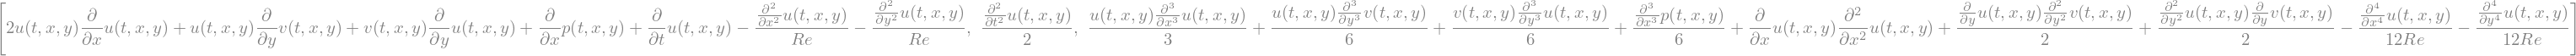

In [45]:
F2

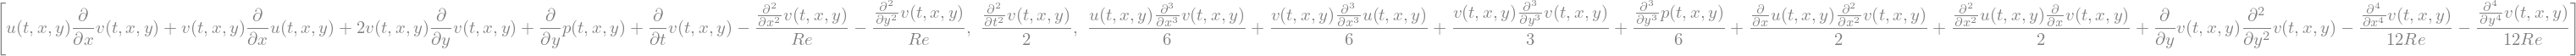

In [46]:
F3

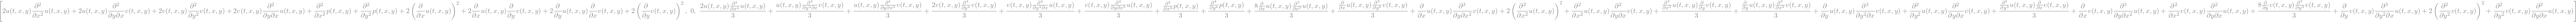

In [47]:
F4

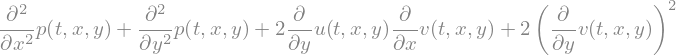

tau =>


h^2 =>


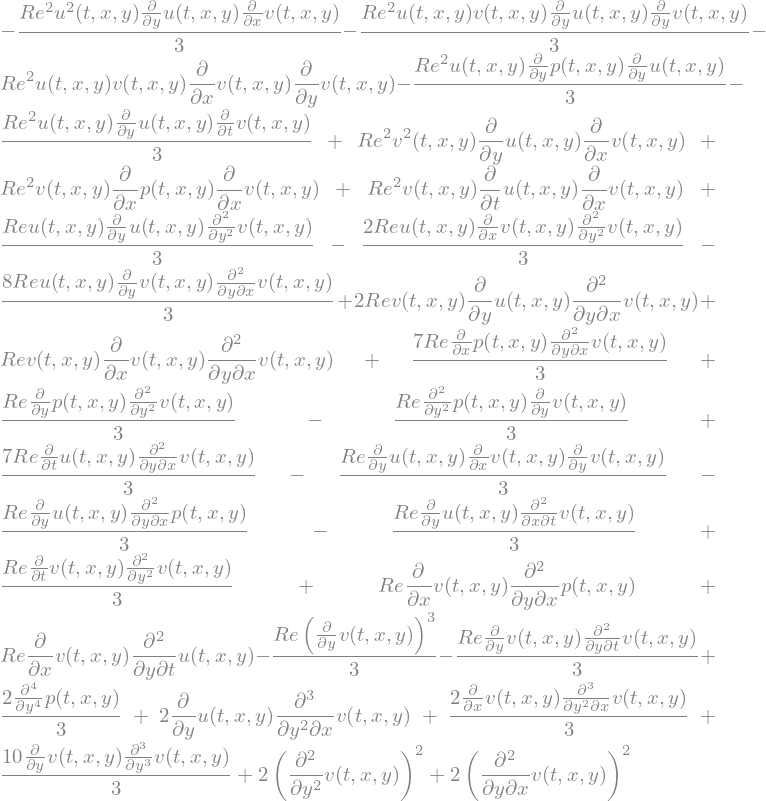

In [48]:
f4 = NF(F4, [u.diff(x), u.diff(y, 2), v.diff(x, 2)], [F1, F2, F3], head=True)
f4 = NF(f4, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [F1, F2, F3, f4])
prn(f4)

In [49]:
prn([f.subs(TD).doit().simplify() for f in f4])

tau =>


h^2 =>


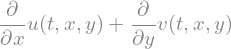

tau =>


h^2 =>


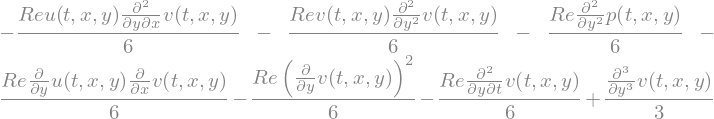

In [50]:
f1 = NF(F1, [u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [F2, F3, f4], head=True)
f1 = NF(f1, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, F2, F3, f4])
prn(f1)

In [51]:
prn([f.subs(TD).doit().simplify() for f in f1])

tau =>


h^2 =>


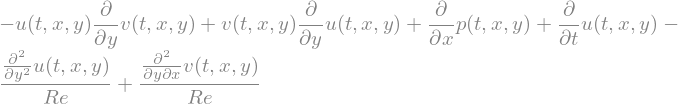

tau =>


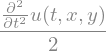

h^2 =>


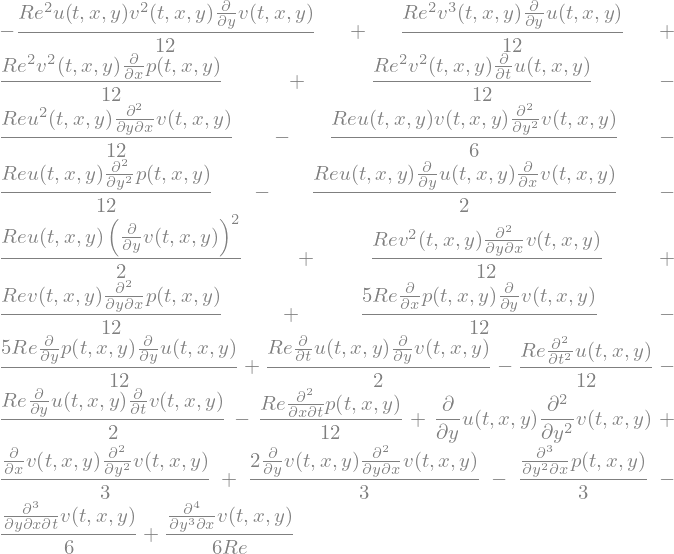

In [52]:
f2 = NF(F2, [u.diff(x), v.diff(x, 2), p.diff(x, 2)], [f1, F3, f4], head=True)
f2 = NF(f2, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, F3, f4])
prn(f2)

tau =>


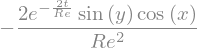

h^2 =>


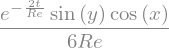

In [53]:
prn([f.subs(TD).doit().simplify() for f in f2])

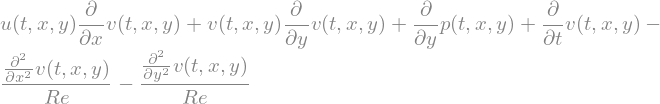

tau =>


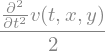

h^2 =>


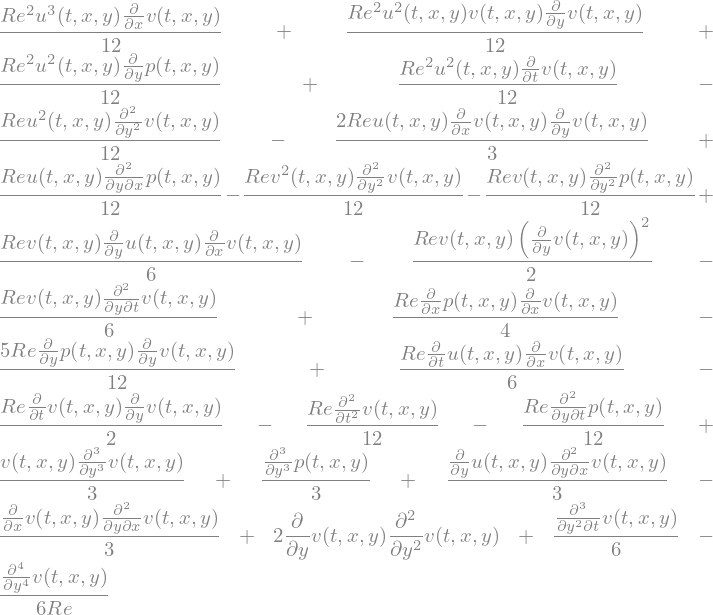

In [54]:
f3 = NF(F3, [u.diff(x), u.diff(y, 2), p.diff(x, 2)], [f1, f2, f4], head=True)
f3 = NF(f3, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, f3, f4])
prn(f3)

tau =>


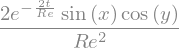

h^2 =>


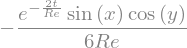

In [55]:
prn([f.subs(TD).doit().simplify() for f in f3])

In [56]:
spoly = [a.diff(x) + b.diff(y) for a, b in zip(f2, f3)]
spoly = NF(spoly, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, f3, f4], head=True)
prn(spoly)

tau =>


h^2 =>


In [57]:
prn([f.subs(TD).doit().simplify() for f in spoly])

tau =>


h^2 =>


In [58]:
prn([f.subs(KF).doit().simplify() for f in spoly])

tau =>


h^2 =>


# FDA4

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{D_1}(u) + \operatorname{D_2}(v)=0 ,\\[4pt]
F^2:& \operatorname{D_t}(u) + u\operatorname{D_1}(u)+
v\operatorname{D_2}(u) + 
\operatorname{D_1}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (u)
=0 ,\\[4pt]
F^3:& \operatorname{D_t}(v) + u\operatorname{D_1}(v)+
v\operatorname{D_2}(v) +
\operatorname{D_2}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (v)
=0 ,\\[4pt]
F^4:& \left(\operatorname{D_1}^2 + \operatorname{D_2}^2\right)(p) 
    + \operatorname{D_1}(u\operatorname{D_1}(u))
    + \operatorname{D_2}(v\operatorname{D_2}(v)) + {} \\
&{} +  \operatorname{D_1}(v\operatorname{D_2}(u))
    + \operatorname{D_2}(u\operatorname{D_1}(v))
- \frac{1}{\mathrm{Re}}\tilde{\Delta}(F^1)
=0 .
\end{array}
\right. 
\end{equation}

In [59]:
F1 = clip(Dx(u) + Dy(v))
F2 = clip(Dt(u) + u*Dx(u) + v*Dy(u) + Dx(p) - DD(u)/Re)
F3 = clip(Dt(v) + u*Dx(v) + v*Dy(v) + Dy(p) - DD(v)/Re)
F4 = clip(DD2(p) + Dx(u*Dx(u)) + Dy(v*Dy(v)) + Dx(v*Dy(u)) + Dy(u*Dx(v)) - (DDx(u) + DDy(v))/Re)

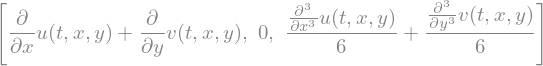

In [60]:
F1

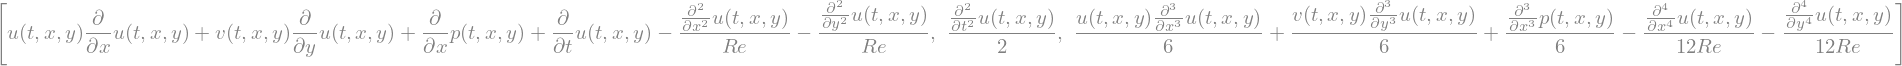

In [61]:
F2

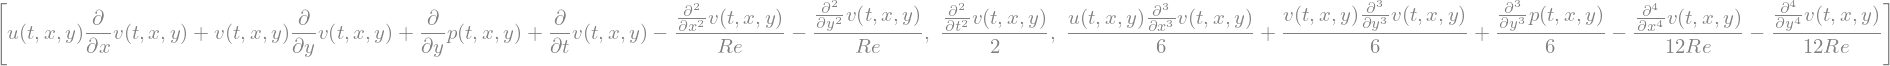

In [62]:
F3

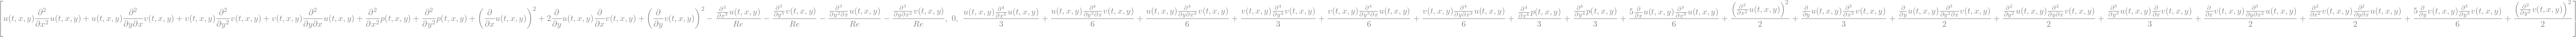

In [63]:
F4

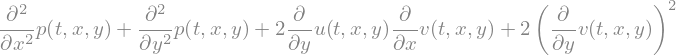

tau =>


h^2 =>


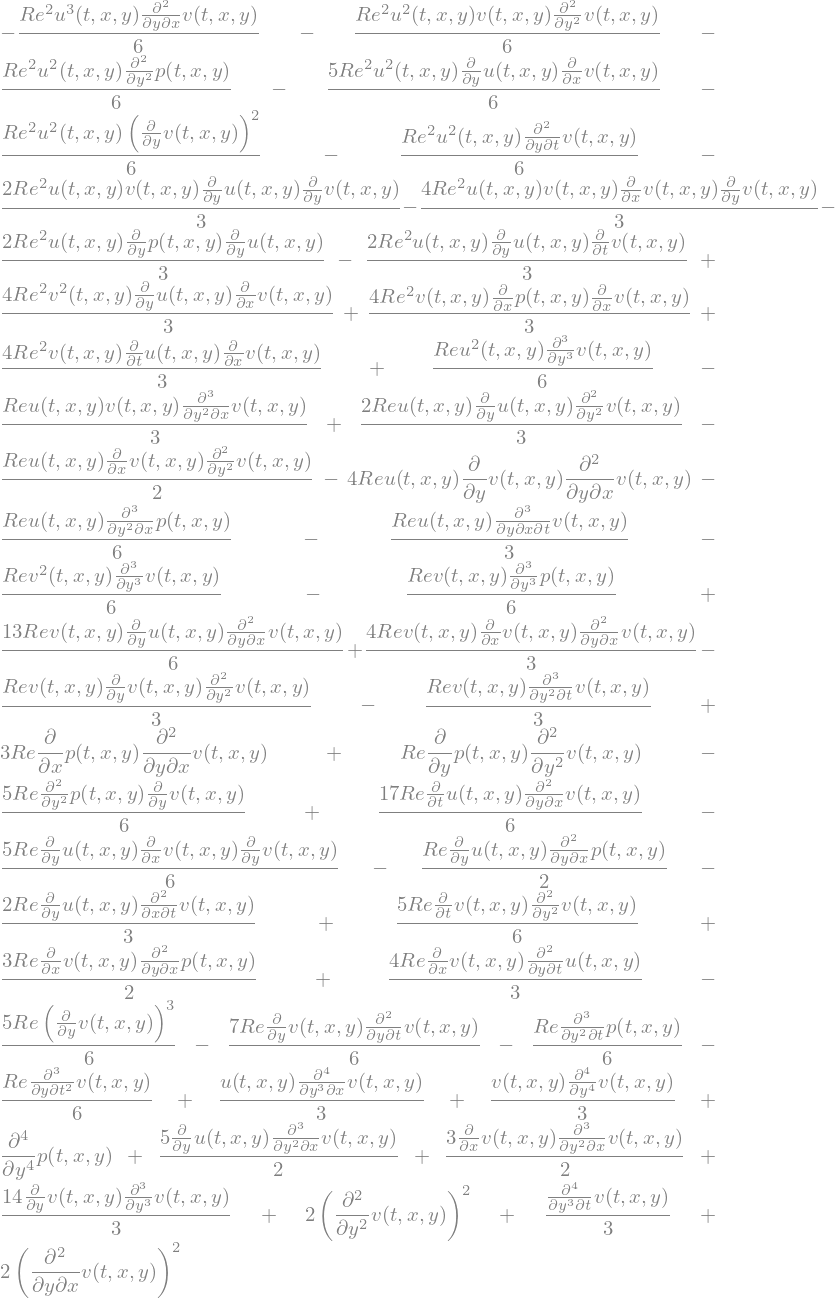

In [64]:
f4 = NF(F4, [u.diff(x), u.diff(y, 2), v.diff(x, 2)], [F1, F2, F3], head=True)
f4 = NF(f4, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [F1, F2, F3, f4])
prn(f4)

In [65]:
prn([f.subs(TD).doit().simplify() for f in f4])

tau =>


h^2 =>


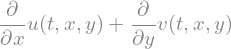

tau =>


h^2 =>


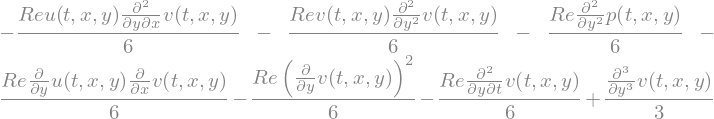

In [66]:
f1 = NF(F1, [u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [F2, F3, f4], head=True)
f1 = NF(f1, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, F2, F3, f4])
prn(f1)

In [67]:
prn([f.subs(TD).doit().simplify() for f in f1])

tau =>


h^2 =>


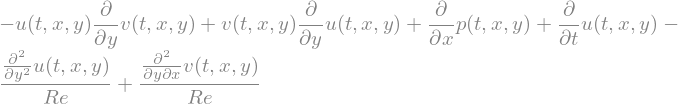

tau =>


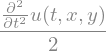

h^2 =>


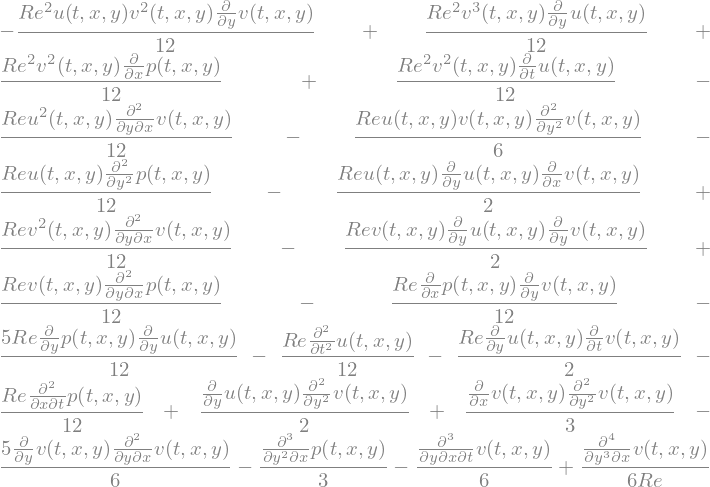

In [68]:
f2 = NF(F2, [u.diff(x), v.diff(x, 2), p.diff(x, 2)], [f1, F3, f4], head=True)
f2 = NF(f2, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, F3, f4])
prn(f2)

tau =>


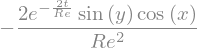

h^2 =>


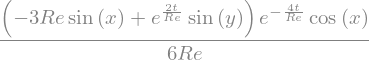

In [69]:
prn([f.subs(TD).doit().simplify() for f in f2])

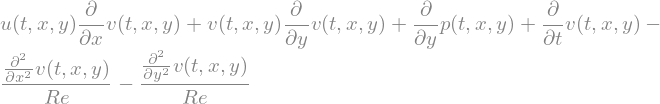

tau =>


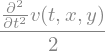

h^2 =>


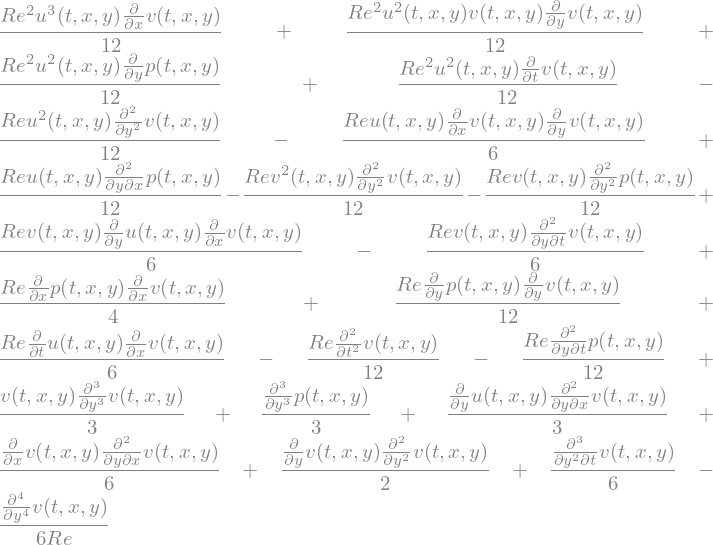

In [70]:
f3 = NF(F3, [u.diff(x), u.diff(y, 2), p.diff(x, 2)], [f1, f2, f4], head=True)
f3 = NF(f3, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, f3, f4])
prn(f3)

tau =>


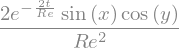

h^2 =>


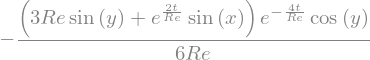

In [71]:
prn([f.subs(TD).doit().simplify() for f in f3])

tau =>


h^2 =>


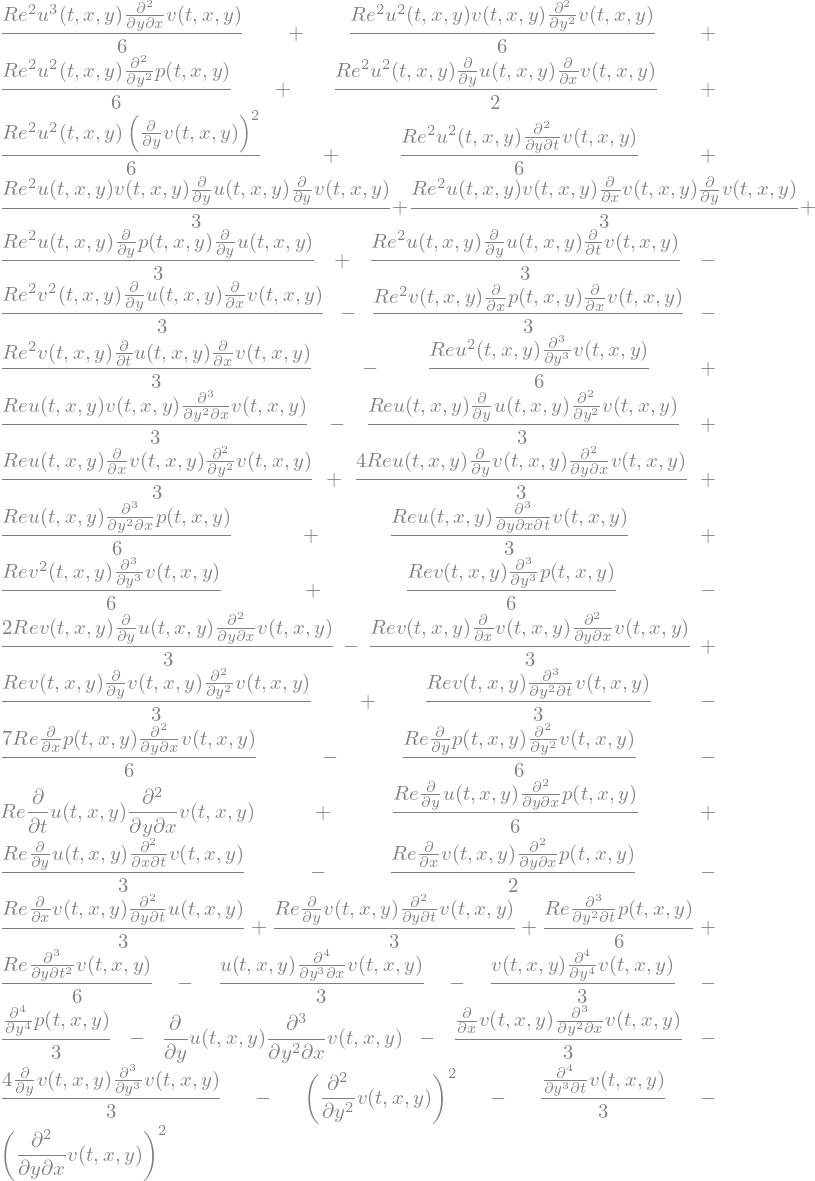

In [72]:
spoly = [a.diff(x) + b.diff(y) for a, b in zip(f2, f3)]
spoly = NF(spoly, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, f3, f4], head=True)
prn(spoly)

In [73]:
prn([f.subs(TD).doit().simplify() for f in spoly])

tau =>


h^2 =>


tau =>


h^2 =>


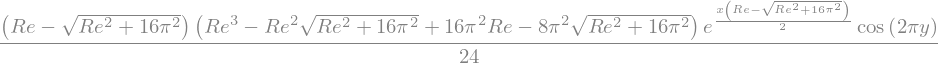

In [74]:
prn([f.subs(KF).doit().simplify() for f in spoly])

# MAC

In [75]:
p12 = Rational(1, 2)

def F(j):
    return T(u, 0, j, 0) + tau/h*(\
        (T(u, 0, j+1, 0) - 2*T(u, 0, j, 0) + T(u, 0, j-1, 0))/(Re*h) +\
        (T(u, 0, j, 1) -   2*T(u, 0, j, 0) + T(u, 0, j, -1))/(Re*h) -\
        ((T(u, 0, j+1, 0) + T(u, 0, j, 0))**2 - (T(u, 0, j, 0) + T(u, 0, j-1, 0))**2)/4 -\
        ((T(u, 0, j, 1) + T(u, 0, j, 0)) *(T(v, 0, j+1, p12)  + T(v, 0, j-1, p12)) -\
         (T(u, 0, j, 0) + T(u, 0, j, -1))*(T(v, 0, j+1, -p12) + T(v, 0, j-1, -p12)))/4)

def G(k):
    return T(v, 0, 0, k) + tau/h*(\
        (T(v, 0, 1, k) -   2*T(v, 0, 0, k) + T(v, 0, -1, k))/(Re*h) +\
        (T(v, 0, 0, k+1) - 2*T(v, 0, 0, k) + T(v, 0, 0, k-1))/(Re*h) -\
        ((T(u, 0, p12, k+1)  + T(u, 0, p12, k-1))* (T(v, 0, 1, k) + T(v, 0, 0, k)) -\
         (T(u, 0, -p12, k+1) + T(u, 0, -p12, k-1))*(T(v, 0, 0, k) + T(v, 0, -1, k)))/4 -\
        ((T(v, 0, 0, k+1) + T(v, 0, 0, k))**2 - (T(v, 0, 0, k) + T(v, 0, 0, k-1))**2)/4)

<img src="./F17.13.png"/>
<img src="./F17.8.png"/>
<img src="./F17.10.png"/>

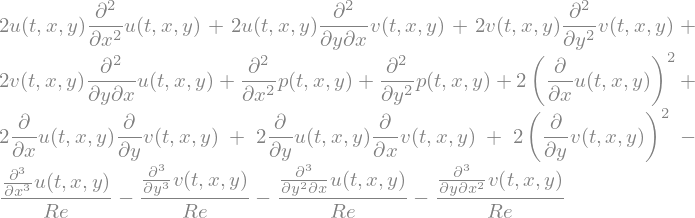

tau =>


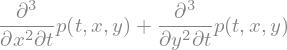

h^2 =>


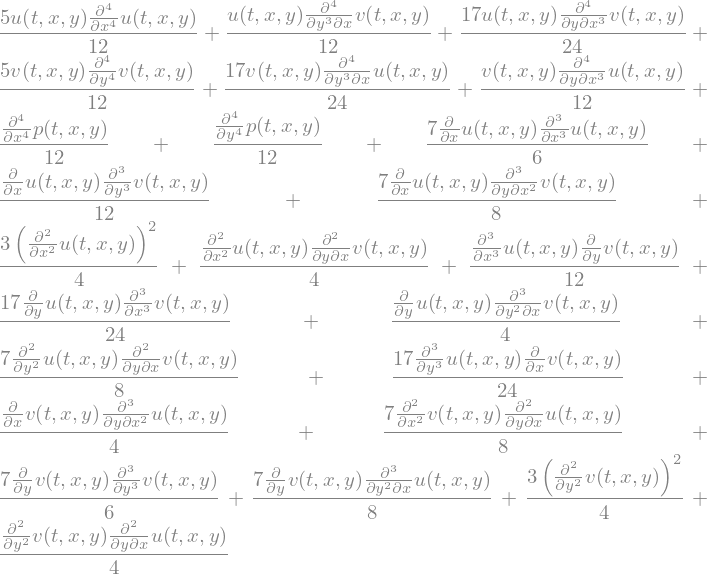

In [76]:
F4 = clip((T(p, 1, 1, 0) - 2*T(p, 1, 0, 0) + T(p, 1, -1, 0))/h**2 +\
          (T(p, 1, 0, 1) - 2*T(p, 1, 0, 0) + T(p, 1, 0, -1))/h**2 -\
         ((F(p12) - F(-p12)) + (G(p12) - G(-p12)))/(tau*h))
prn(F4)

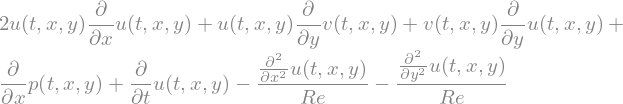

tau =>


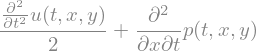

h^2 =>


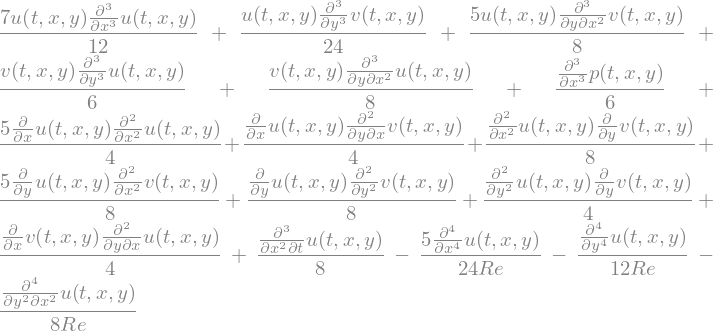

In [77]:
F2 = clip((T(u, 1, p12, 0) - F(p12))/tau +\
          (T(p, 1, 1, 0) - T(p, 1, 0, 0))/h)
prn(F2)

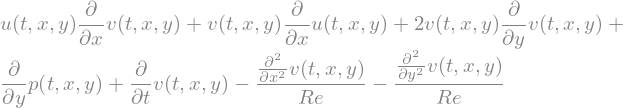

tau =>


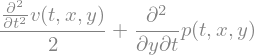

h^2 =>


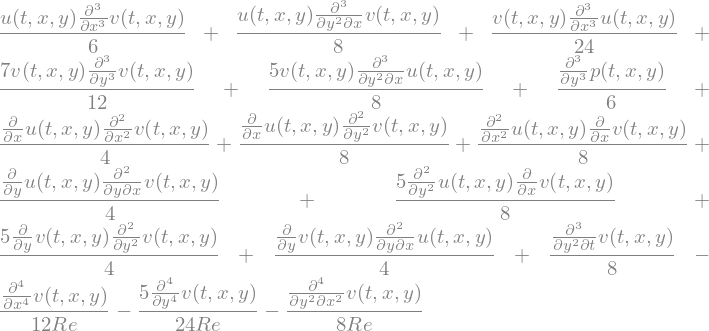

In [78]:
F3 = clip((T(v, 1, 0, p12) - G(p12))/tau +\
          (T(p, 1, 0, 1) - T(p, 1, 0, 0))/h)
prn(F3)

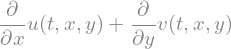

tau =>


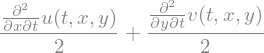

h^2 =>


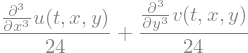

In [79]:
F1 = clip(((T(u, 0, p12, 0) - T(u, 1, -p12, 0)) +\
           (T(v, 0, 0, p12) - T(v, 1, 0, -p12)))/h)
prn(F1)

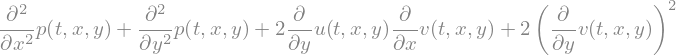

tau =>


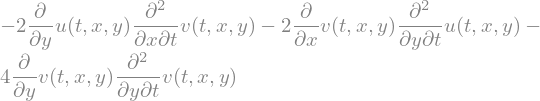

h^2 =>


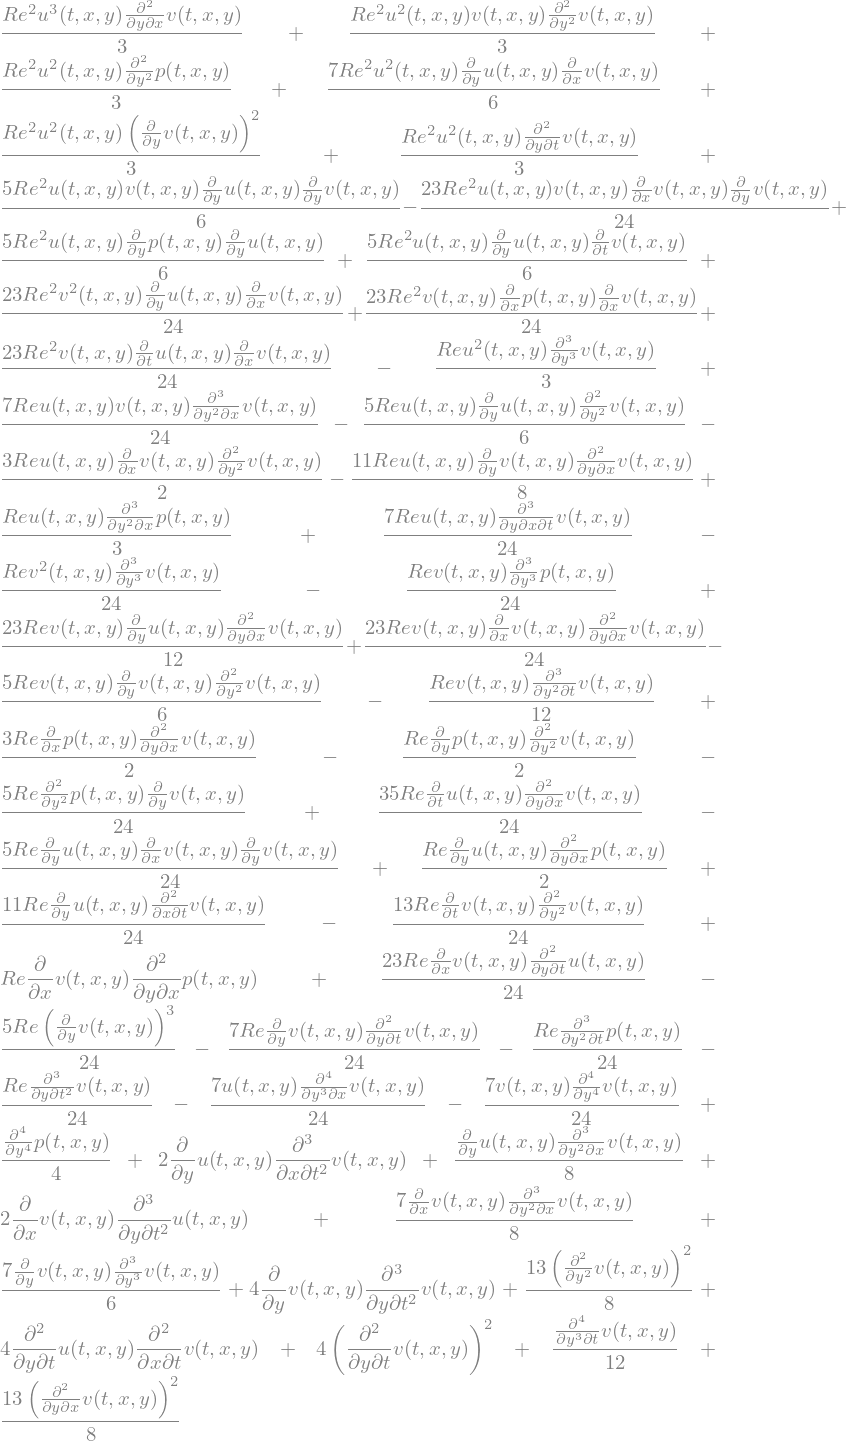

In [80]:
f4 = NF(F4, [u.diff(x), u.diff(y, 2), v.diff(x, 2)], [F1, F2, F3], head=True)
f4 = NF(f4, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [F1, F2, F3, f4])
prn(f4)

tau =>


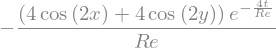

h^2 =>


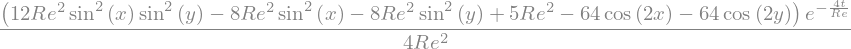

In [81]:
prn([f.subs(TD).doit().simplify() for f in f4])

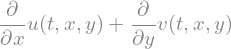

tau =>


h^2 =>


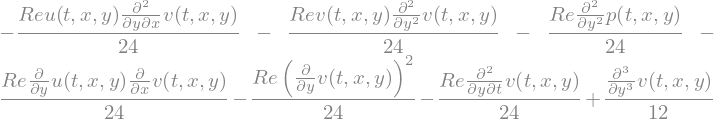

In [82]:
f1 = NF(F1, [u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [F2, F3, f4], head=True)
f1 = NF(f1, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, F2, F3, f4])
prn(f1)

In [83]:
prn([f.subs(TD).doit().simplify() for f in f1])

tau =>


h^2 =>


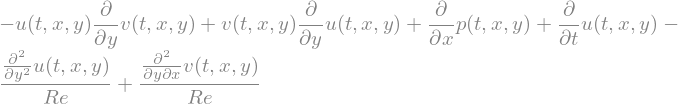

tau =>


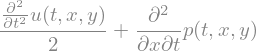

h^2 =>


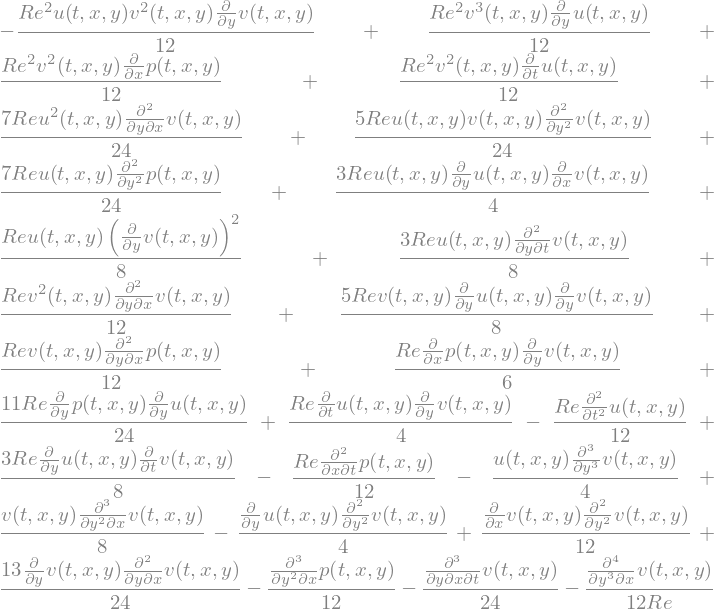

In [84]:
f2 = NF(F2, [u.diff(x), v.diff(x, 2), p.diff(x, 2)], [f1, F3, f4], head=True)
f2 = NF(f2, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, F3, f4])
prn(f2)

tau =>


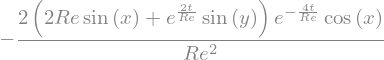

h^2 =>


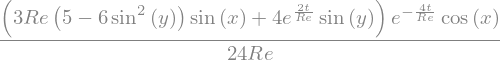

In [85]:
prn([f.subs(TD).doit().simplify() for f in f2])

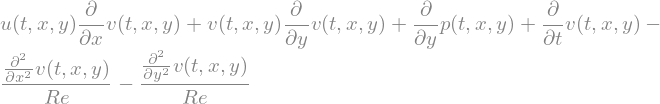

tau =>


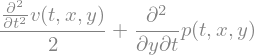

h^2 =>


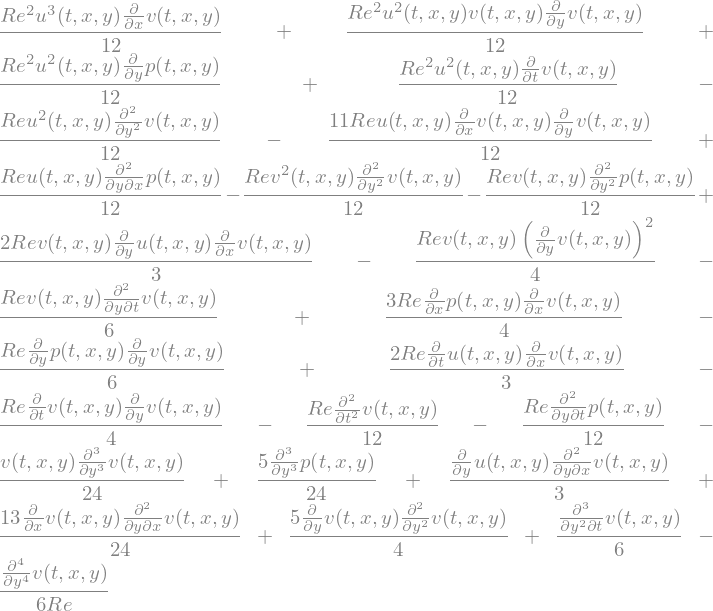

In [86]:
f3 = NF(F3, [u.diff(x), u.diff(y, 2), p.diff(x, 2)], [f1, f2, f4], head=True)
f3 = NF(f3, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, f3, f4])
prn(f3)

tau =>


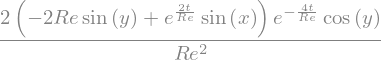

h^2 =>


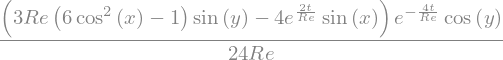

In [87]:
prn([f.subs(TD).doit().simplify() for f in f3])

tau =>


h^2 =>


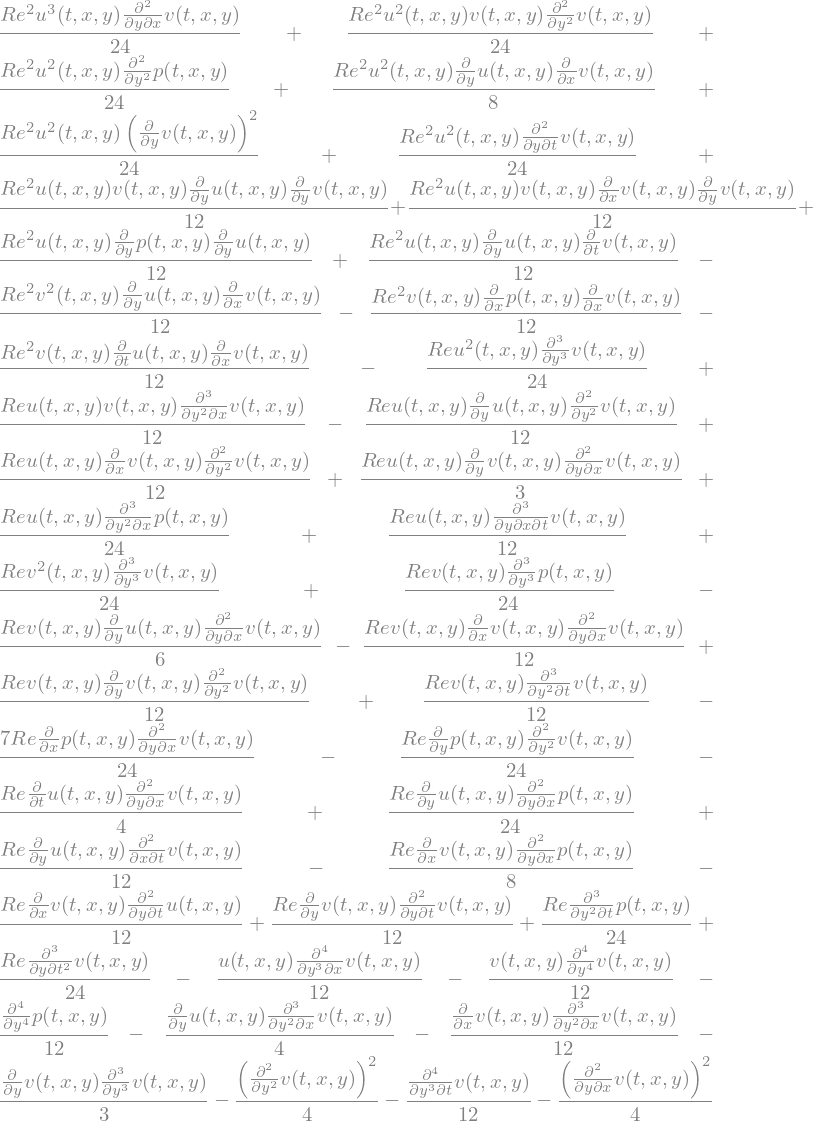

In [88]:
spoly = [a.diff(x) + b.diff(y) for a, b in zip(f2, f3)]
spoly = NF(spoly, [u.diff(x), u.diff(y, 2), v.diff(x, 2), p.diff(x, 2)], [f1, f2, f3, f4], head=True)
prn(spoly)

In [89]:
prn([f.subs(TD).doit().simplify() for f in spoly])

tau =>


h^2 =>


tau =>


h^2 =>


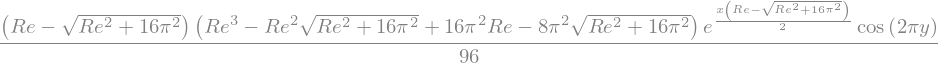

In [90]:
prn([f.subs(KF).doit().simplify() for f in spoly])